# Energy Regression example in the Aleph simulated data

### Data:
The input variables (X) are (where Aleph uses only the first six):
* **prob_b**: Probability of being a b-jet from the pointing of the tracks to the vertex.
* **spheri**: Sphericity of the event, i.e. how spherical it is.
* **pt2rel**: The transverse momentum squared of the tracks relative to the jet axis, i.e. width of the jet.
* **multip**: Multiplicity of the jet (in a relative measure).
* **bqvjet**: b-quark vertex of the jet, i.e. the probability of a detached vertex.
* **ptlrel**: Transverse momentum (in GeV) of possible lepton with respect to jet axis (about 0 if no leptons).
* energy: Measured energy of the jet in GeV. Should be 45 GeV, but fluctuates.
* cTheta: cos(theta), i.e. the polar angle of the jet with respect to the beam axis. Note, that the detector works best in the central region (|cTheta| small) and less well in the forward regions.
* phi:    The azimuth angle of the jet. As the detector is uniform in phi, this should not matter (much).
* isb:    1 if it is from a b-quark and 0, if it is not.
* nnbjet: Value of original Aleph b-jet tagging algorithm, using only the last six variables (for reference).


### Task:
Thus, the task before you is to produce functions (non-ML and then ML algorithm), which given the input variables X provides an output variable estimate, y_pred, which is "closest possible" to the target variable, y. The "closest possible" is left to the user to define in a _Loss Function_. 

* Author: Arnau Morancho Tardà (NBI) and Rasmus Ørsøe (NBI)
* Email:  arnau.morancho@nbi.ku.dk
* Date:   4th of May 2023

In [1]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import numpy as np
import csv

import time

In [2]:
r = np.random
r.seed(42)

SavePlots = False
plt.close('all')

# Read the data

We choose input and target variables:

* 'energy', 'cTheta', and 'phi' are kinematic variables of the jet, and not about the jet type.
   They are good variables for using regression algorithms. In particular, we will predict the energy, which is not cyclic and therefore less considerations need to take into account. We encourage you trying or thinking about how to solve the cyclic problem for 'cTheta' and 'phi'.

Usually one would apply further checks/regularization/standardization of data at this step, but this data has already been "prepared", so we'll move onto seperate the data into input and truth:

In [3]:
#We import the data slightly more convenient here
import pandas as pd 
from pandas import Series, DataFrame 

# Read the data in using Pandas Dataframe and print the variables:
data = pd.DataFrame(np.genfromtxt('../../Week1/AlephBtag_MC_train_Nev50000.csv', names=True))
#data = pd.DataFrame(np.genfromtxt('AlephBtag_MC_train_Nev50000.csv', names=True))

variables = data.columns
print(variables)

# Decide on which variables to use for input (X) and what defines the label (Y):
input_variables = variables[(variables != 'nnbjet') & (variables != 'isb') & (variables != 'energy') & (variables != 'cTheta') & (variables != 'phi')]
input_data      = data[input_variables]
truth_data      = data['energy']
print("  Variables used for training: ", input_variables)

Index(['energy', 'cTheta', 'phi', 'prob_b', 'spheri', 'pt2rel', 'multip',
       'bqvjet', 'ptlrel', 'nnbjet', 'isb'],
      dtype='object')
  Variables used for training:  Index(['prob_b', 'spheri', 'pt2rel', 'multip', 'bqvjet', 'ptlrel'], dtype='object')


***

# Regression using LightGBM:

This is a solution example using LightGBM (tree based).

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import lightgbm as lgb
from lightgbm import early_stopping
from scipy.stats import gaussian_kde

In [5]:
X_train, X_test, y_train, y_test = train_test_split(input_data, truth_data, test_size=0.25, random_state=42)

In [6]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval  = lgb.Dataset(X_test,  y_test, reference=lgb_train)
params = {
    'boosting_type': 'gbdt', # Traditional Gradient Boosting tree, we are combining many 'weak' learners here!
    'objective': 'regression',   # The outcome is binary, b-quark or not
    'num_leaves': 10,         # Set a maximum tree leaves to avoid overfitting
    'learning_rate': 0.03,
    'verbose':-1,            # Suppress some output
}

# Train the model:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                callbacks=[early_stopping(40)])     # Stops if no improvement is seen in N rounds.

Training until validation scores don't improve for 40 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 22.1931


In [7]:
# Make predictions:
y_pred_lgbm = gbm.predict(X_test)  # Scores are floats in the range ]0,1[.
# accuracy check
mse = mean_squared_error(y_test, y_pred_lgbm)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)

MSE: 22.19
RMSE: 4.71


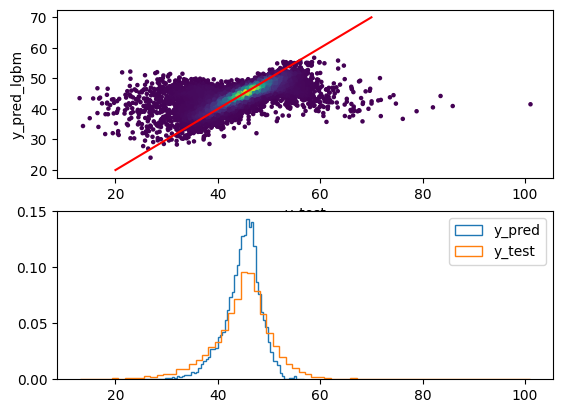

In [8]:
x = np.linspace(20,70,100)
y = x

# Calculate the point density
xy = np.vstack([y_test,y_pred_lgbm])
z = gaussian_kde(xy)(xy)

fig, axs = plt.subplots(2)
axs[0].scatter(y_test,y_pred_lgbm, c=z, s=5)
axs[0].plot(x, y, '-r')
axs[0].set_xlabel('y_test')
axs[0].set_ylabel('y_pred_lgbm')
axs[1].hist(y_pred_lgbm, alpha=1 ,histtype='step', density=True, bins=70, label='y_pred')
axs[1].hist(y_test,alpha=1 ,histtype='step', density=True, bins=70, label='y_test')
axs[1].legend()

## Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

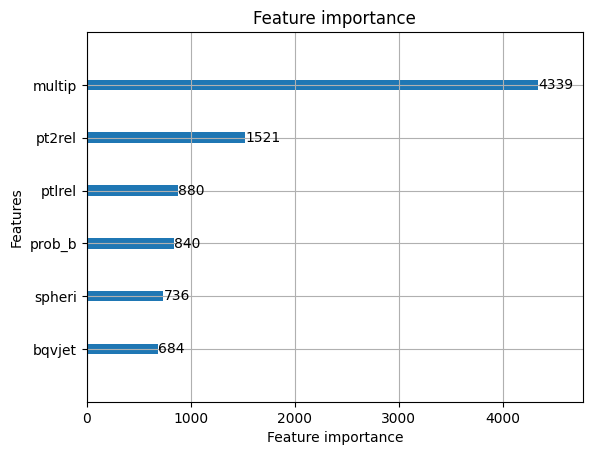

In [9]:
lgb.plot_importance(gbm, max_num_features=6)

In [10]:
feature_imp = pd.DataFrame({'Value':gbm.feature_importance(),'Feature':X_train.columns})
idx_feat = gbm.feature_importance().argsort()[-4:]
imp_var = X_train.columns[idx_feat]
imp_var

Index(['prob_b', 'ptlrel', 'pt2rel', 'multip'], dtype='object')

## Permutation importance

In [11]:
from sklearn.inspection import permutation_importance
gbm = lgb.LGBMRegressor()
r = permutation_importance(gbm.fit(X_test, y_test), X_test, y_test,
                            n_repeats=30,
                            random_state=42)
importances = r.importances_mean
importances

array([0.07775809, 0.04327368, 0.25526786, 0.48664849, 0.05212004,
       0.12957682])

(0.0, 0.7)

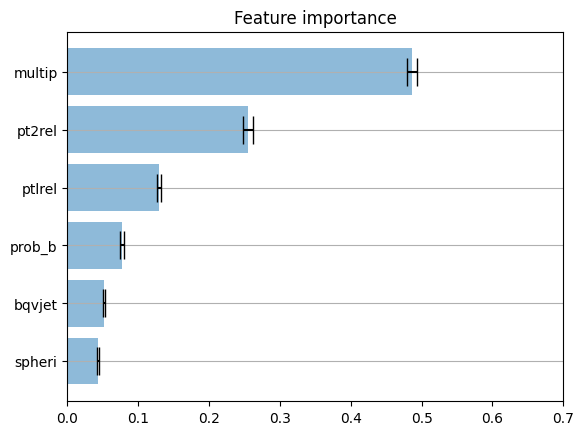

In [12]:
# Build the plot
sorted_indices = importances.argsort()
fig,ax = plt.subplots()

ax.barh(np.arange(0,len(importances),1), importances[sorted_indices], xerr=r.importances_std[sorted_indices], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_yticks(np.arange(0,len(importances),1))
ax.set_yticklabels(input_variables[sorted_indices])
ax.set_title('Feature importance')
ax.yaxis.grid(True)
ax.set_xlim(0,0.7)

## Shap values

In [13]:
import shap

explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_test)

In [18]:
shap_values

array([[ 0.07160173, -0.02549182, -2.36823757, -2.90136852,  0.25406887,
         0.32634417],
       [ 0.00459774,  0.09199853,  2.37603277, -0.28617205, -0.09471255,
         0.3326431 ],
       [-0.23387319,  0.07749416,  1.62421619, -2.78517839,  0.23121353,
        -1.51309833],
       ...,
       [ 0.2087599 , -0.01065987, -1.59458861, -0.72388216, -0.17303667,
         0.49509605],
       [ 0.39575243,  0.22699722, -0.65136575, -3.26133758,  0.1706217 ,
         0.29998459],
       [ 0.30040605, -0.05504298, -0.19072489,  1.43932004, -0.60066804,
        -2.16121438]])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


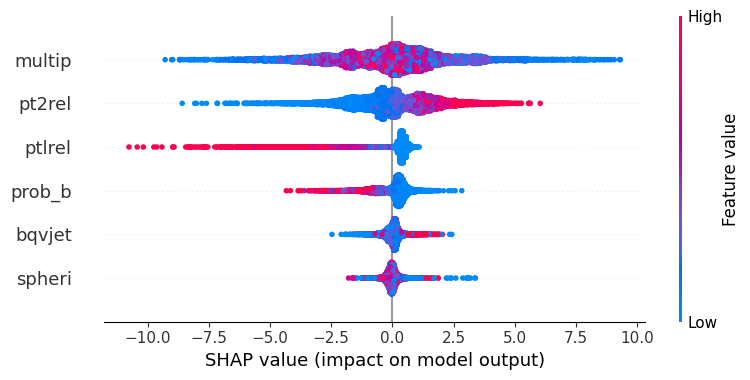

In [14]:
shap.summary_plot(shap_values, X_test)
# Other type of plots:
# shap.summary_plot(shap_values, X_test, plot_type="bar")

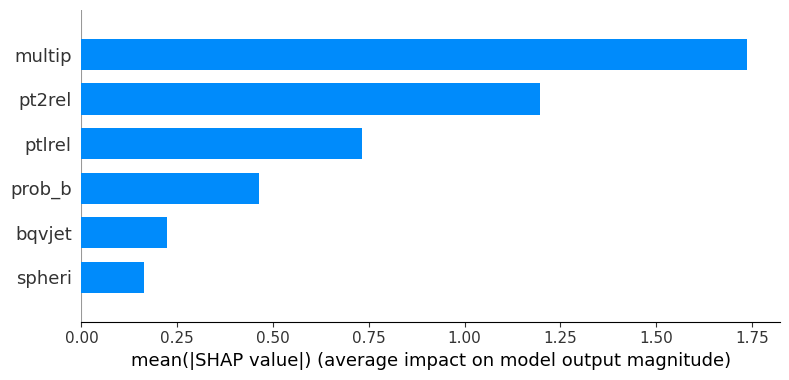

In [17]:
shap.summary_plot(shap_values, X_test, plot_type="bar")